<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Pre_%26_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

#  Feature scaling

In [18]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv'):
  correlation_data = min_max_scaling(correlation_data)
  correlation_data.to_csv(r'./corr_data.csv')

if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  correlation_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv')

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

Rimpiazzo i missing values in categorical data con unknown. 

Unisco i dataset numerici e categorici nel dataframe data. 

Riferimento fillna: https://jamesrledoux.com/code/imputation

In [20]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  col_to_drop = col_not_sign(categorical_data, cat_sign_col)
  categorical_data = categorical_data.drop(col_to_drop, axis=1)
  categorical_data = categorical_data.fillna('unknown')
  data = pd.merge(correlation_data, categorical_data, left_on='TransactionID', right_on='TransactionID', how='left')
  del correlation_data, categorical_data, numerical_data
  data.to_csv(r'./data.csv')

data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

# Feature engineering

In [21]:
# Riferimento: https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm
def feature_extraction(data):
  data = device(data)
  data = os_(data)
  data = browser(data)
  data = screen(data)
  data = id_23_34(data)
  data.drop(columns = ['DeviceInfo', 'id_30', 'id_31', 'id_33', 'id_34', 'id_23'], inplace=True)

  data = date(data)
  return data

def device_name(data):
  data['device_name'] = data['DeviceInfo'].str.split('/', expand=True)[0]
  device_dict = {
      'SM': 'Samsung',
      'SAMSUNG': 'Samsung',
      'GT-': 'Samsung',
      'Moto G': 'Motorola',
      'Moto': 'Motorola',
      'moto': 'Motorola',
      'LG-': 'LG',
      'rv:': 'RV',
      'HUAWEI': 'Huawei',
      'ALE-': 'Huawei',
      '-L': 'Huawei',
      'Blade': 'ZTE',
      'BLADE': 'ZTE',
      'Linux': 'Linux',
      'XT': 'Sony',
      'HTC': 'HTC',
      'ASUS': 'Asus'
        }
  for device in device_dict:
    data.loc[data['device_name'].str.contains(device, na=False), 'device_name'] = device_dict[device]
  data.loc[data.device_name.isin(data.device_name.value_counts()[data.device_name.value_counts() < 200].index), 'device_name'] = "Others"
  return data

def device(data):
  data['device_version'] = data['DeviceInfo'].str.split('/', expand=True)[1]
  return data

def os_(data):
  data['os_name'] = data['id_30'].str.split(' ', expand=True)[0]
  data['os_version'] = data['id_30'].str.split(' ', expand=True)[1]
  return data

def browser(data):
  data['browser_name'] = data['id_31'].str.split(' ', expand=True)[0]
  data['bro wser_version'] = data['id_31'].str.split(' ', expand=True)[1]
  return data

def screen(data):
  data['screen_w'] = data['id_33'].str.split('x', expand=True)[0]
  data['screen_h'] = data['id_33'].str.split('x', expand=True)[1]
  return data

def id_23_34(data):
  data['id_23'] = data['id_23'].str.split(':', expand=True)[1]
  data['id_34'] = data['id_34'].str.split(':', expand=True)[1]  
  return data

def date(data):
  data['day'] = np.floor((data['TransactionDT'] / (3600 * 24) - 1) % 7)
  data['hour'] = np.floor(data['TransactionDT'] / 3600) % 24
  return data

data = feature_extraction(data)

# One hot encoding

One hot encoding delle features categoriche. Serve per lo smote e easy ensemble. 

Bisogna farlo prima dello split del dataset poichè rischio di perdere delle colonne. 

In [22]:
data = pd.get_dummies(data)

In [23]:
cols = mf.get_col(data)

Seleziono i dati appartenenti ai primi 60 giorni. 

Se ne seleziono di più, l'easy ensemble non va. 

In [24]:
data = mf.select_days(data, 60)

Splitto il dataset in train, validation e test set. 

In [25]:
X_train, X_val, y_train, y_val = mf.split(data, test_size = 0.2)
del data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Undersampling: Easy Ensemble

L'easy ensemble tramite un metodo unsupervised divide il dataset in diversi dataset undersampled. 

Documentazione easy ensemble: http://glemaitre.github.io/imbalanced-learn/generated/imblearn.ensemble.EasyEnsemble.html#imblearn.ensemble.EasyEnsemble

Esempio applicazio ee: http://glemaitre.github.io/imbalanced-learn/auto_examples/ensemble/plot_easy_ensemble.html?highlight=easy%20ensemble

In [26]:
X_trainres, y_trainres = mf.easy_ensemble(5, X_train, y_train)

In [27]:
X_trainres_df = pd.DataFrame(data = X_trainres[0], columns = cols)
del X_trainres

# XGBoost

Provo a trainare un random forest con cross validation sui vari dataset splittati attraverso easy ensemble. 

ROC curve: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_roc_curve_visualization_api.html#sphx-glr-auto-examples-miscellaneous-plot-roc-curve-visualization-api-py

XGBoost: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

gpu_hist method: https://xgboost.readthedocs.io/en/latest/parameter.html#additional-parameters-for-hist-and-gpu-hist-tree-method

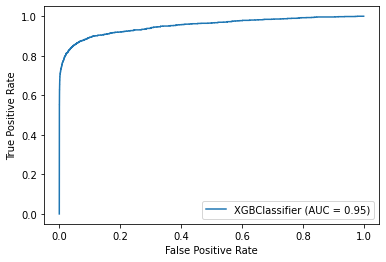

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import plot_roc_curve
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators = 4000, max_depth = 10, #alpha=0.5, 
                    objective='binary:logistic', learning_rate = 0.5, 
                    tree_method='gpu_hist') 

# clf.fit(X_trainres_df, y_trainres[0])
clf.fit(X_train, y_train)
plot_roc_curve(clf, X_val, y_val)
plt.show()

AP max = 0.79

AP: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

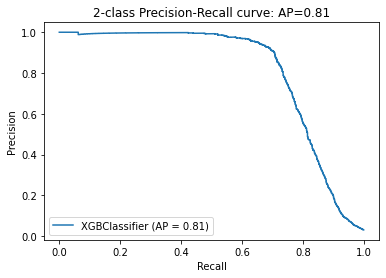

In [55]:
mf.ap_metric(clf, X_val, y_val, proba = True)

In [ ]:
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp[:20].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### ROC AUC curve

Riferimento: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

In [ ]:
mf.roc_auc_subset(XGBClassifier(), X_trainres, y_trainres, X_val, y_val)